# Semi-Supervised Learning with VAEs

## Overview
Semi-supervised learning with Variational Autoencoders (VAEs) is a powerful approach that combines labeled and unlabeled data to improve performance in classification and generative tasks. This method is especially useful when labeled data is scarce, as VAEs can extract meaningful features from unlabeled data.

---

## Key Concepts

### 1. Variational Autoencoder (VAE) Recap
- **Encoder**: Maps input data \( x \) to a latent representation \( z \).
- **Decoder**: Reconstructs \( x \) from \( z \).
- **Loss Function**: Combines reconstruction loss (measuring reconstruction quality) and KL divergence (ensuring the latent space follows a normal distribution):
  \[
  \mathcal{L}_{\text{VAE}} = \text{Reconstruction Loss} + \text{KL Divergence}
  \]

### 2. Semi-Supervised Learning
Semi-supervised learning uses both:
- **Labeled Data** (\( x, y \)): Data with known labels for supervised learning.
- **Unlabeled Data** (\( x \)): Data without labels for unsupervised learning.

In a semi-supervised VAE:
- The labeled data helps the model learn accurate classification.
- The unlabeled data improves the latent space representation.

### 3. Shared Latent Space
Both labeled and unlabeled data share the same latent space \( z \), ensuring consistency and better generalization.

---

## Workflow

### **For Labeled Data (\( \mathcal{D}_l \))**
1. Encode \( x \) and \( y \) into \( z \).
2. Use \( z \) to:
   - Reconstruct \( x \) (using the decoder).
   - Predict \( y \) (using the classifier).
3. Supervised Loss:
   \[
   \mathcal{L}_{\text{sup}} = \text{Reconstruction Loss} + \text{Classification Loss}
   \]

### **For Unlabeled Data (\( \mathcal{D}_u \))**
1. Predict possible labels \( y \) for \( x \).
2. Encode \( x \) and predicted \( y \) into \( z \).
3. Reconstruct \( x \) from \( z \).
4. Unsupervised Loss:
   \[
   \mathcal{L}_{\text{unsup}} = \text{Reconstruction Loss} + \text{KL Divergence}
   \]

### **Total Loss**
The combined loss function is:
\[
\mathcal{L} = \mathcal{L}_{\text{sup}} + \mathcal{L}_{\text{unsup}}
\]

---

## Advantages
1. **Data Efficiency**: Uses a small amount of labeled data effectively.
2. **Improved Representations**: Leverages large unlabeled datasets for feature learning.
3. **Better Generalization**: Achieves better performance on unseen data by combining labeled and unlabeled data.

---

## Applications
1. **Text Classification**: Predicting sentiment with limited labeled data.
2. **Image Recognition**: Classifying images like MNIST digits or CIFAR-10 objects.
3. **Anomaly Detection**: Identifying rare patterns by learning from unlabeled data.

---

## Key Takeaways
- Semi-supervised VAEs are ideal for scenarios with limited labeled data.
- They combine supervised and unsupervised learning to create a shared latent space for better generalization.
- This technique is valuable for real-world applications, research, and job interviews.


Epoch 1/50, Loss: 92.85487365722656
Epoch 2/50, Loss: 66.66043090820312
Epoch 3/50, Loss: 62.76198959350586
Epoch 4/50, Loss: 58.338626861572266
Epoch 5/50, Loss: 56.998130798339844
Epoch 6/50, Loss: 55.11765670776367
Epoch 7/50, Loss: 53.83812713623047
Epoch 8/50, Loss: 53.204891204833984
Epoch 9/50, Loss: 52.541011810302734
Epoch 10/50, Loss: 51.622779846191406
Epoch 11/50, Loss: 51.41499328613281
Epoch 12/50, Loss: 51.10932159423828
Epoch 13/50, Loss: 51.61027908325195
Epoch 14/50, Loss: 51.25811767578125
Epoch 15/50, Loss: 51.082672119140625
Epoch 16/50, Loss: 50.70768737792969
Epoch 17/50, Loss: 50.46050262451172
Epoch 18/50, Loss: 49.41103744506836
Epoch 19/50, Loss: 48.86056137084961
Epoch 20/50, Loss: 49.00563049316406
Epoch 21/50, Loss: 48.73442459106445
Epoch 22/50, Loss: 48.58517074584961
Epoch 23/50, Loss: 48.590030670166016
Epoch 24/50, Loss: 47.760555267333984
Epoch 25/50, Loss: 48.3165283203125
Epoch 26/50, Loss: 47.74172592163086
Epoch 27/50, Loss: 47.5745849609375
Epoc

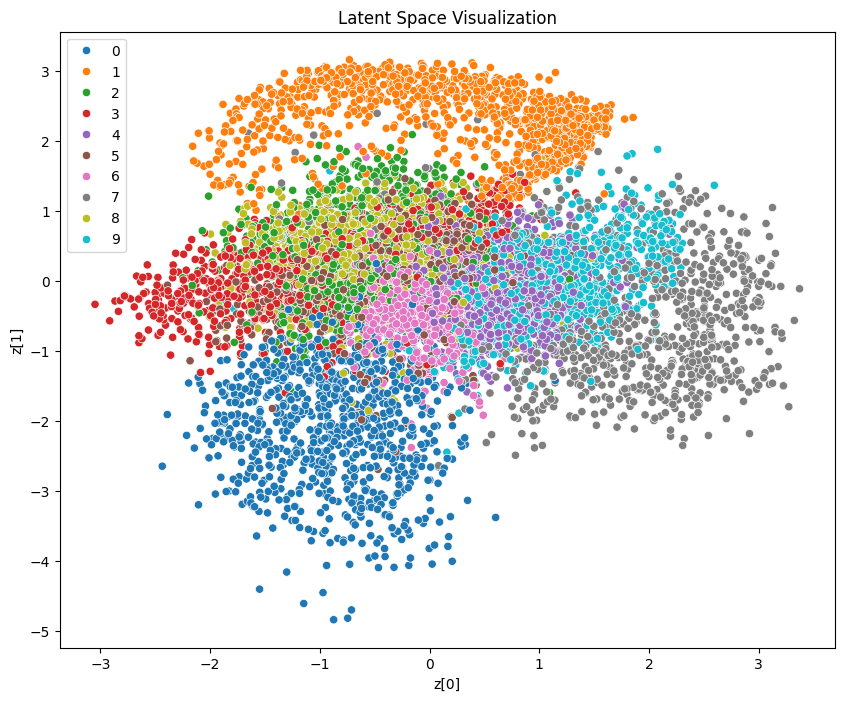

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Separate labeled and unlabeled data
num_labeled = 1000  # Only a small subset is labeled
x_labeled, y_labeled = x_train[:num_labeled], y_train[:num_labeled]
x_unlabeled = x_train[num_labeled:]

# Define model dimensions
input_dim = 28 * 28
latent_dim = 2
num_classes = 10

# Encoder
def build_encoder(input_dim, latent_dim):
    inputs = Input(shape=(input_dim,))
    h = Dense(512, activation="relu")(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    z = Lambda(lambda x: x[0] + tf.exp(0.5 * x[1]) * tf.random.normal(shape=(tf.shape(x[0])[0], latent_dim)))(
        [z_mean, z_log_var]
    )
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
def build_decoder(latent_dim, output_dim):
    latent_inputs = Input(shape=(latent_dim,))
    h = Dense(512, activation="relu")(latent_inputs)
    outputs = Dense(output_dim, activation="sigmoid")(h)
    return Model(latent_inputs, outputs, name="decoder")

# Classifier
def build_classifier(latent_dim, num_classes):
    latent_inputs = Input(shape=(latent_dim,))
    h = Dense(128, activation="relu")(latent_inputs)
    outputs = Dense(num_classes, activation="softmax")(h)
    return Model(latent_inputs, outputs, name="classifier")

# Build components
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)
classifier = build_classifier(latent_dim, num_classes)

# VAE Model
inputs = Input(shape=(input_dim,))
z_mean, z_log_var, z = encoder(inputs)
reconstructed = decoder(z)
predicted_label = classifier(z)

# Custom loss function
def vae_loss(inputs, reconstructed, z_mean, z_log_var, y_labeled, predicted_label):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(inputs - reconstructed), axis=1))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
    classification_loss = tf.reduce_mean(sparse_categorical_crossentropy(y_labeled, predicted_label))
    total_loss = reconstruction_loss + kl_loss + classification_loss
    return total_loss

# Create the model and compile
vae = Model(inputs, [reconstructed, predicted_label], name="vae")

# Define the loss function for the model
@tf.function
def compute_loss(inputs, reconstructed, z_mean, z_log_var, y_labeled, predicted_label):
    return vae_loss(inputs, reconstructed, z_mean, z_log_var, y_labeled, predicted_label)

# Custom training loop
@tf.function
def train_step(inputs, y_labeled):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder(inputs)
        reconstructed = decoder(z)
        predicted_label = classifier(z)
        loss = compute_loss(inputs, reconstructed, z_mean, z_log_var, y_labeled, predicted_label)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Optimizer
optimizer = Adam(learning_rate=1e-3)

# Training the model with custom loop
epochs = 50
batch_size = 64
for epoch in range(epochs):
    for i in range(0, len(x_labeled), batch_size):
        batch_inputs = x_labeled[i:i+batch_size]
        batch_labels = y_labeled[i:i+batch_size]
        batch_inputs = tf.convert_to_tensor(batch_inputs)
        batch_labels = tf.convert_to_tensor(batch_labels)

        loss = train_step(batch_inputs, batch_labels)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy()}")

# Visualization of Latent Space
z_mean_test, _, _ = encoder.predict(x_test)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_mean_test[:, 0], y=z_mean_test[:, 1], hue=y_test, palette="tab10", legend="full")
plt.title("Latent Space Visualization")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

# Save and Load Model
vae.save("semi_supervised_vae.h5")
